# Demo of endpoint variant_distribution

Documentation: http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.variant_distribution

Requirements to run this demo: https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/README_requirements

Try this demo online: https://colab.research.google.com/drive/1l0ux51MceYTSwLTHV5kUIhPsWtKzp_PQ

This time, we are going to select all the individuals originating from the American and South Asian continents, who have two variants located on opposite chromosome copies of the hg19 reference assembly. We refer to these variants through an identifier assigned from dbSNP. 

Given this sample set, we ask for the distribution of the variant (target_variant) with id 'rs72670621' with respect to the gender and super_population attributes (distribute_by).

In [13]:
import json
param = {
    'distribute_by': ['gender', 'super_population'],
    'having_meta': {
        'super_population': ['AFR', 'SAS'],
        'assembly': 'hg19'
    },
    'having_variants': {
        'on_diff_chrom_copy': [{'id': 'rs367896724'}, {'id': 'rs555500075'}]
    },
    'target_variant': {'id': 'rs72670621'}
}

POST the endpoint \variant_distribution with the prepared JSON parameter and query parameters.

In [14]:
import requests

r = requests.post('http://geco.deib.polimi.it/popstudy/api/variant_distribution', json=param)
print(' response status code: {}'.format(r.status_code))
response_body = r.json()

response status code: 200


# Inspect response data:
It is a data cube with the numerosity of the individuals grouped on the free-dimensions: gender, dna_source and population (to be intended as country of origin)

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
columns = response_body['columns']
rows = response_body['rows']
df = pd.DataFrame.from_records(rows, columns=columns)
df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df0 = df.pivot_table(df, ['SUPER_POPULATION', 'GENDER'])
df0['POSITIVE_RATIO'] = df0.apply(lambda r: r['POSITIVE_DONORS']/r['POPULATION_SIZE'], axis=1)
df0

FREQUENCY  OCCURRENCE_OF_TARGET_VARIANT  \
SUPER_POPULATION GENDER                                            
                          0.147766                            86   
                 female   0.164336                            47   
                 male     0.131757                            39   
AFR                       0.214689                            76   
                 female   0.221649                            43   
                 male     0.206250                            33   
SAS                       0.043860                            10   
                 female   0.043478                             4   
                 male     0.044118                             6   

                         POPULATION_SIZE  POSITIVE_DONORS  POSITIVE_RATIO  
SUPER_POPULATION GENDER                                                    
                                     291               76        0.261168  
                 female              143               42        0.293706  
                 male                148               34        0.229730  
AFR                                  177               66        0.372881  
                 female               97               38        0.391753  
                 male                 80               28        0.350000  
SAS                                  114               10        0.087719  
                 female               46                4        0.086957  
                 male                 68                6        0.088235

The selected popualtion counts of 291 donors, but only 76 of them show the target variant, more or less 1/4. Nevertheless, most of the positive donors have only 1 occurrence of such variant (i.e. it is rarely a homozygous variant), so that is why the overall frequency is actually much less: 14,7%.

Let's see how the individuals are distributed inside the different continents:

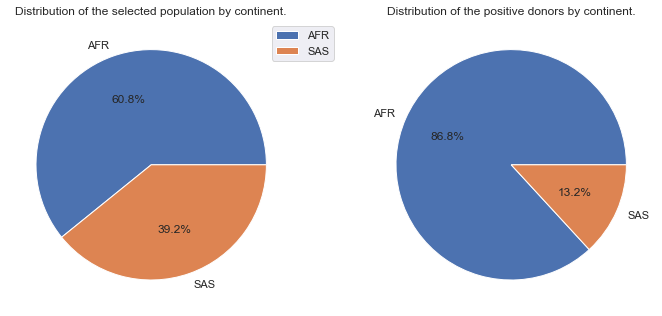

In [16]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning) # seaborn needs to update its import -> ignore warning 
import seaborn as sns
# use Seaborn styles
sns.set()

df10 = df.drop(df.query('GENDER != "" | SUPER_POPULATION == ""').index)  # remove rows where gender is not empty or super_population is any
# we prepare two data frames, one containing the population_size, and the other one containing the positive donors.
df11 = df10.drop(['GENDER', 'OCCURRENCE_OF_TARGET_VARIANT', 'FREQUENCY', 'POSITIVE_DONORS'], inplace=False, axis=1) # remove unnecesary columns
df11 = df11.pivot_table(df11, index=['SUPER_POPULATION'])

df12 = df10.drop(['GENDER', 'OCCURRENCE_OF_TARGET_VARIANT', 'FREQUENCY', 'POPULATION_SIZE'], inplace=False, axis=1) # remove unnecesary columns
df12 = df12.pivot_table(df12, index=['SUPER_POPULATION'])


fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(df11['POPULATION_SIZE'], labels=df11.index.tolist(), autopct='%1.1f%%')
ax1.set_title('Distribution of the selected population by continent.')

ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(df12['POSITIVE_DONORS'], labels=df12.index.tolist(), autopct='%1.1f%%')
ax2.set_title('Distribution of the positive donors by continent.')

ax1.legend(bbox_to_anchor=(.9, 1.0))    # place only one legend beacuse the index for the two data frames is the same
plt.show()


We notice that the criteria used for selecting the population - the presence of variants rs367896724 and rs555500075 on opposite chromatids - have a greater compatibility in the African population than in the Asian one.  60% vs 40%.

Also, the number of individuals resulting positive to the target varaint are far more in the African individuals. Let's compare the frequency of the variant by continent then:

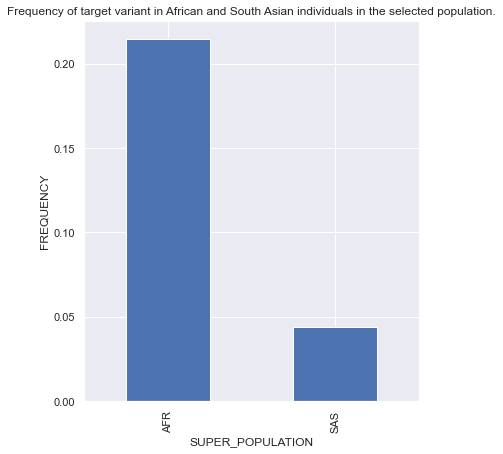

In [17]:
df2 = df.drop(df.query('GENDER != "" | SUPER_POPULATION == ""').index)
df2.drop(['POPULATION_SIZE', 'POSITIVE_DONORS', 'OCCURRENCE_OF_TARGET_VARIANT', 'GENDER'], inplace=True, axis=1)
df2.pivot_table(df2, index='SUPER_POPULATION').plot(
    kind='bar',
    figsize=(6, 7),
    legend=False
)
plt.title('Frequency of target variant in African and South Asian individuals in the selected population.')
plt.ylabel('FREQUENCY')
plt.show()

This shows a much larger adoption of the target variant rs72670621 in the African population: ~4 times more. Such increment does not seem to be correlated to the larger number of African individuals, which corresponds to 60.8% of the total, i.e. just 1.55 times more the number of South Asian individuals.  

Notice that we could have expressed all the variant identifiers in this notebook also by their coordinates (chrom, start, reference and alternative alleles) obtaining the same results.